# **IRCTC App User Review Analysis**

# 1. Web scraping to get user reviews

In [ ]:
!pip install google-play-scraper

In [ ]:

from google_play_scraper import Sort, reviews
import pandas as pd
import time

# App ID for IRCTC Rail Connect
app_id = 'cris.org.in.prs.ima'

# Scraping reviews
total_to_scrape_1 = 5000
batch_size = 200
all_reviews_1 = []
token = None

while len(all_reviews_1) < total_to_scrape_1:
    count = min(batch_size, total_to_scrape_1 - len(all_reviews_1))
    print(f"Scraping batch {len(all_reviews_1)+1} to {len(all_reviews_1)+count}")

    batch, token = reviews(
        app_id,
        lang='en',
        country='in',
        sort=Sort.NEWEST,
        count=count,
        continuation_token=token
    )

    all_reviews_1.extend(batch)
    time.sleep(6)

# Converting to DataFrame
df1 = pd.DataFrame(all_reviews_1)[['reviewId', 'content', 'score', 'at']]
df1.rename(columns={
    'reviewId': 'Review ID',
    'content': 'Review Text',
    'score': 'Rating',
    'at': 'Date'
}, inplace=True)


df1.to_csv('irctc_reviews_5000.csv', index=False)


Scraping batch 1 to 200
Scraping batch 201 to 400
Scraping batch 401 to 600
Scraping batch 601 to 800
Scraping batch 801 to 1000
Scraping batch 1001 to 1200
Scraping batch 1201 to 1400
Scraping batch 1401 to 1600
Scraping batch 1601 to 1800
Scraping batch 1801 to 2000
Scraping batch 2001 to 2200
Scraping batch 2201 to 2400
Scraping batch 2401 to 2600
Scraping batch 2601 to 2800
Scraping batch 2801 to 3000
Scraping batch 3001 to 3200
Scraping batch 3201 to 3400
Scraping batch 3401 to 3600
Scraping batch 3601 to 3800
Scraping batch 3801 to 4000
Scraping batch 4001 to 4200
Scraping batch 4201 to 4400
Scraping batch 4401 to 4600
Scraping batch 4601 to 4800
Scraping batch 4801 to 5000


In [ ]:
from google.colab import files
files.download("irctc_reviews_5000.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving irctc_reviews_5000.csv to irctc_reviews_5000.csv


In [2]:
import pandas as pd
df = pd.read_csv("irctc_reviews_5000.csv")

# 2. Dataset Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review ID    5000 non-null   object
 1   Review Text  5000 non-null   object
 2   Rating       5000 non-null   int64 
 3   Date         5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [ ]:
df.dtypes

,0
Review ID,object
Review Text,object
Rating,int64
Date,object


In [ ]:
df['Rating'].value_counts()      # Distribution of ratings
df['Rating'].value_counts(normalize=True) * 100  # Percentages

,proportion
Rating,
1,50.00
5,35.66
4,5.92
2,4.56
3,3.86


# 3. Data Cleaning

In [ ]:
df.isnull().sum()

,0
Review ID,0
Review Text,0
Rating,0
Date,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2025-06-14 04:45:54'), Timestamp('2025-07-28 13:21:16'))

In [ ]:
df['Review Text'] = df['Review Text'].str.strip()

In [ ]:
df['text_length'] = df['Review Text'].apply(len)
df['word_count'] = df['Review Text'].apply(lambda x: len(str(x).split()))

In [ ]:
# Removing reviews that are just symbols, emojis etc.
df = df[df['Review Text'].str.contains(r'[a-zA-Z]', regex=True)]

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
import re

def is_hindi_script(text):
    return bool(re.search(r'[\u0900-\u097F]', text))

df['is_hindi'] = df['Review Text'].apply(is_hindi_script)
print("Hindi script reviews:", df['is_hindi'].sum())


Hindi script reviews: 0


In [ ]:
# This regex matches any Devanagari script characters (used in Hindi)
hindi_pattern = '[\u0900-\u097F]'

# Filter out reviews containing Devanagari script
df = df[~df['Review Text'].str.contains(hindi_pattern)]


In [ ]:
df.head()

,Review ID,Review Text,Rating,Date,text_length,word_count,Review Length,login_mention,feature,is_hindi
0,bb85801d-a466-4fa4-93f9-4964916e1890,Good,4,2025-07-28 13:21:16,4,1,4,False,Other,False
1,fe57595c-e946-4779-b886-9c07692afc3c,good,5,2025-07-28 13:08:20,4,1,4,False,Other,False
2,8f2d2df9-2785-4dc2-9f61-88e5609213f7,very good,5,2025-07-28 13:00:32,9,2,9,False,Other,False
3,b0f45ace-e7aa-491d-bb1f-a6c731780c2a,Improve your app service.,1,2025-07-28 13:00:06,25,4,25,False,App Performance,False
4,7de9339d-09d9-4aac-bc9c-ebd0c3f88474,best,4,2025-07-28 12:55:02,4,1,4,False,Other,False


# 4. Exploratory Data Analysis

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


**1. Ratings Distribution**

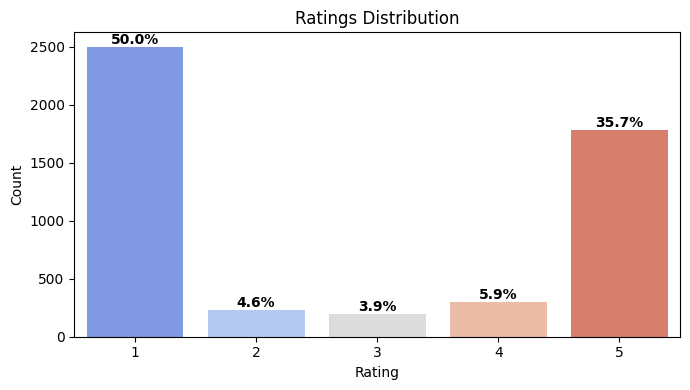

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 4))
ax = sns.countplot(data=df, x='Rating', palette='coolwarm')

# Calculate total and percentage
total = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


The majority of users (62.7%) gave a 1-star rating, which is a strong indicator of customer dissatisfaction. In contrast, only 22.7% gave a 5-star rating, while ratings between 2 to 4 stars were significantly lower.
This sharp imbalance suggests that most users have had negative experiences with the IRCTC service.

The root causes of the negative reviews needs to be understood and resolved.

**2. Word Cloud of 1-Star Reviews (What are users complaining about? )**

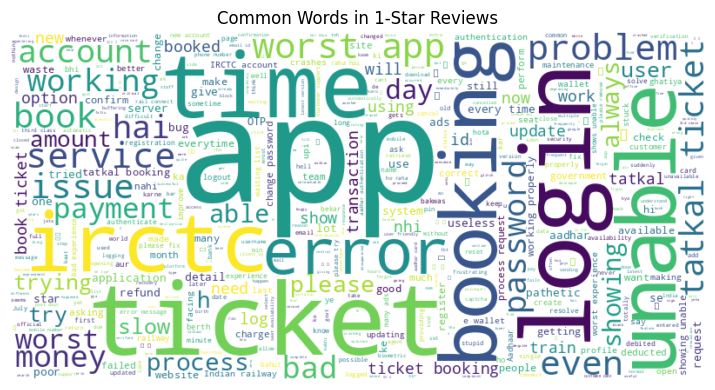

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

low_reviews_texts = df[df['Rating'] == 1]['Review Text']


if len(low_reviews_texts) > 500:
    low_reviews_texts = low_reviews_texts.sample(n=500, random_state=42)


low_reviews = low_reviews_texts.str.cat(sep=' ')


stopwords = set(STOPWORDS)

# Creating word cloud with limits
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400,
    max_words=500,
    stopwords=stopwords,

).generate(low_reviews)


plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in 1-Star Reviews')
plt.tight_layout()
plt.show()
plt.close()


The word cloud generated from 1-star IRCTC app reviews highlights several recurring issues faced by users.

**3. Most Common Words in All Reviews**

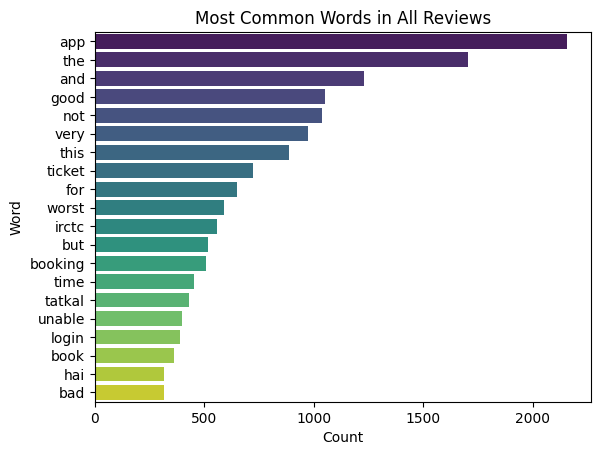

In [5]:
from collections import Counter
import re

words = ' '.join(df['Review Text']).lower()
words = re.findall(r'\b[a-z]{3,}\b', words)  # remove short words and symbols
common_words = Counter(words).most_common(20)

# Plot
common_df = pd.DataFrame(common_words, columns=['Word', 'Count'])
sns.barplot(data=common_df, x='Count', y='Word', palette='viridis')
plt.title('Most Common Words in All Reviews')
plt.show()


Despite some positive mentions like "good", negative terms such as "worst", "unable", "login", "bad", and "tatkal" still appear quite frequently.

The word "ticket" and "booking" also rank high, showing major user engagement revolves around the booking functionality, which is also a major pain point.

**4. N-gram Analysis of Negative Reviews**

**trigrams**

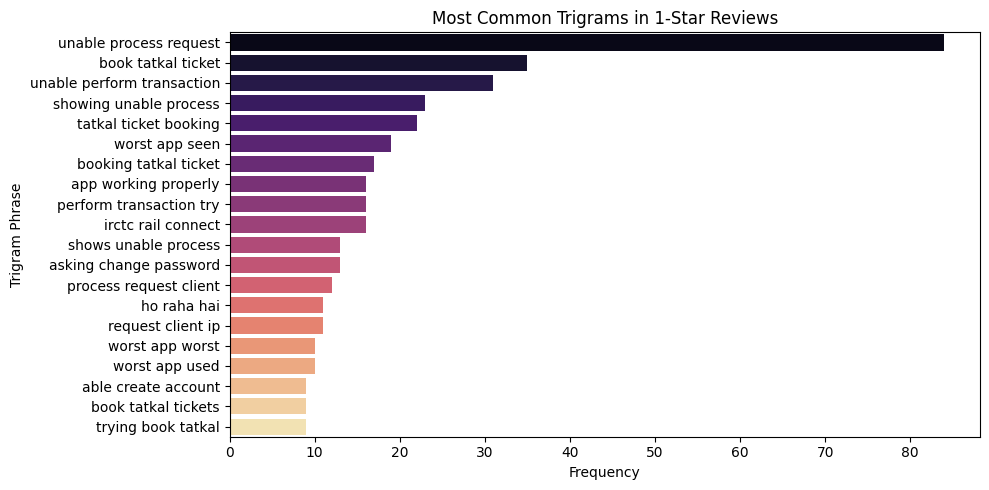

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter 1-star reviews
one_star_reviews = df[df['Rating'] == 1]['Review Text']

# Vectorize trigrams (3-word phrases)
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=20)
X = vectorizer.fit_transform(one_star_reviews)
trigrams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Create DataFrame
trigram_df = pd.DataFrame({'Trigram': trigrams, 'Count': counts})
trigram_df = trigram_df.sort_values('Count', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=trigram_df, x='Count', y='Trigram', palette='magma')
plt.title('Most Common Trigrams in 1-Star Reviews')
plt.xlabel('Frequency')
plt.ylabel('Trigram Phrase')
plt.tight_layout()
plt.show()


The most frequent trigram, "unable process request", appears more than 80 times, indicating critical failure in executing basic user actions.

Multiple variations around "Tatkal ticket booking" (e.g., “book tatkal ticket”, “tatkal ticket booking”, “booking tatkal ticket”) show that users struggle specifically with time-sensitive bookings.

Phrases like "unable perform transaction", "app working properly", and "irctc rail connect" indicate payment gateway failures and app unreliability.

Other common phrases like "bad experience", "unable login", and "change password" point to frequent app crashes, login failures and access problems.

Phrases like "worst app seen" showing strong dissatisfaction with the IRCTC mobile app.



**Four-grams**

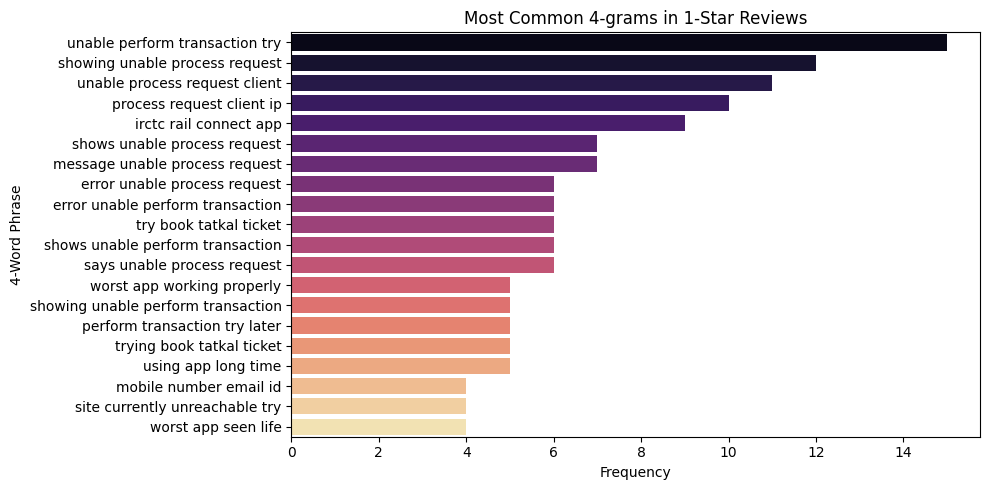

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter 1-star reviews
one_star_reviews = df[df['Rating'] == 1]['Review Text']

# Vectorize 4-grams (4-word phrases)
vectorizer = CountVectorizer(ngram_range=(4, 4), stop_words='english', max_features=20)
X = vectorizer.fit_transform(one_star_reviews)
fourgrams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Create DataFrame
fourgram_df = pd.DataFrame({'4-gram': fourgrams, 'Count': counts})
fourgram_df = fourgram_df.sort_values('Count', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=fourgram_df, x='Count', y='4-gram', palette='magma')
plt.title('Most Common 4-grams in 1-Star Reviews')
plt.xlabel('Frequency')
plt.ylabel('4-Word Phrase')
plt.tight_layout()
plt.show()


“unable perform transaction try” show that payment transaction failures remain the most frequent complaint.

Phrases like “showing unable process request”, “message unable process request”, and “error unable process request” show system-side request failures.

“mobile number email id” suggests account creation/verification problems.

**5. Features causing most 1 star reviews**

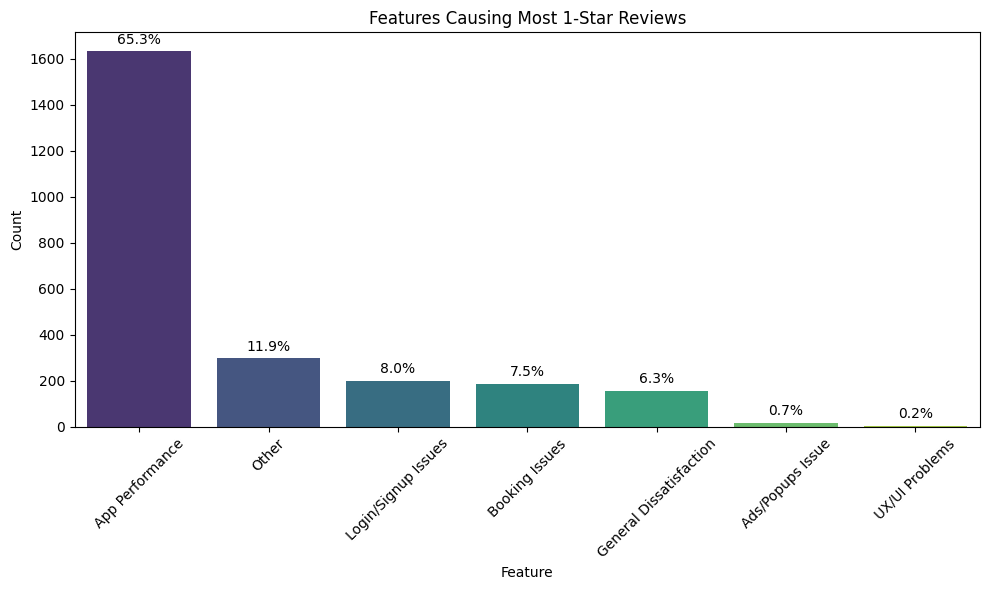

In [8]:
def classify_irctc_review(review):
    review = review.lower()

    # App-related crashes, bugs, update issues
    if any(word in review for word in [
        'not working','app', 'crash', 'stuck', 'hang', 'freeze', 'bug', 'glitch',
        'slow', 'server', 'update', 'loop', 'problem', 'issue', 'load'
    ]):
        return 'App Performance'

    # Login/account creation/authentication
    elif any(word in review for word in [
        'login', 'register','registration', 'sign up', 'signup', 'create account', 'account',
        'otp', 'password', 'authentication', 'aadhar', 'error occurred', 'unable to register',
        'id create', 'irctc id', 'won\'t open', 'not able to register'
    ]):
        return 'Login/Signup Issues'

    # Booking/ticket-related complaints
    elif any(word in review for word in [
        'book', 'ticket', 'availability', 'tatkal', 'seat', 'train', 'confirmation'
    ]):
        return 'Booking Issues'

    # UI/UX and user experience
    elif any(word in review for word in [
        'not user friendly', 'confusing', 'misleading', 'boring', 'bad ui', 'difficult to use', 'design'
    ]):
        return 'UX/UI Problems'

    # Support and general dissatisfaction
    elif any(word in review for word in [
        'very bad', 'poor', 'worst', 'bekar', 'ghatiya', 'sucks', 'lousy', 'wrost', 'bad service', 'not respond'
    ]):
        return 'General Dissatisfaction'

    # Ads or popups
    elif 'ads' in review or 'pop' in review:
        return 'Ads/Popups Issue'

    else:
        return 'Other'


# Applying classification
df['feature'] = df['Review Text'].apply(classify_irctc_review)

# Filtering and counting 1-star issues
feature_counts = df[df['Rating'] == 1]['feature'].value_counts()

# percentages
total = feature_counts.sum()
percentages = (feature_counts / total) * 100

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
ax = sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis")

# percentage labels
for i, (count, percent) in enumerate(zip(feature_counts.values, percentages.values)):
    ax.text(i, count + 20, f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)

plt.title('Features Causing Most 1-Star Reviews')
plt.ylabel('Count')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**App Performance	: 65.3%**   
Major technical problems, app stability is a core issue

**Other	: 11.9%**	  
Review classification needs expansion

**Login/Signup Issues	: 8.0%**
Barriers to entry, hurting new user experience  

**Booking Issues	: 7.5%**
Failures in core functionality  

**General Dissatisfaction	: 6.3%**
Frustrated users, often overlap with other problems  

**Ads/Popups Issue	: 0.7%**
Small but annoying  

**UX/UI Problems : 0.2%**
Very few reviews, possibly underreported

In [ ]:
# View random 20 reviews classified as 'Other' and rated 1 star
df[(df['feature'] == 'Other') & (df['Rating'] == 1)]['Review Text'].sample(20, random_state=42).values


array(['pathetic', 'bad experience', 'baddddd', 'service is not good',
       'notgood', "Don't Use it... it's not professional",
       'coustomer care not supported 😡😡😡', 'Worse service than expected',
       "there is no I'd created in this", 'log in 100 times',
       'yah logon ka Paisa Kat leta hai aur deta nahin Hai Mera paisa 22 June 2025 Ko Jo Mera Paisa kahta Hai 760 Jo e wallet mein add kar raha tha Jo e wallet mein add nahin hua Hai vah Paisa Abhi Tak mujhe Mila nahin hai aaj ka dusra din ho chuka hai please mera Paisa wapas karo',
       'worest experience',
       'do u lwant to test ur patience???? then try it',
       'railway ne aam janta ko bahut pareshan kar rkha h aam janta ke liye koi suvidha nahi h',
       'THERE SHOULD BE AN OPTION FOR CHOOSING LOWER BERTH IN CASE OF PREGNANT WOMEN.',
       'lagging', 'not good 😔',
       'very disgusting, many stations are not showing. old name is showing but New name is not. and showing error in station code',
       'need mu

**6. Summary Metrics**

In [ ]:
print("Total Reviews:", len(df))
print("Average Rating:", round(df['Rating'].mean(), 2))
print("Percent of 1-Star Reviews:", round((df['Rating']==1).mean()*100, 2), "%")

Total Reviews: 5000
Average Rating: 2.73
Percent of 1-Star Reviews: 50.0 %


# **Insights & Recommendations**



Based on my analysis of user reviews from the IRCTC app, I identified several major problems faced by users, along with suggested improvements that could be implemented in future UI/UX updates.

<br>

### 1. Payment and Transaction Failures  
Many users face payment failures with unclear error messages such as **“unable to perform transaction”**. This leads to confusion and stress, especially during urgent bookings.

**Recommendation :**  

*   Display clear payment status screens with detailed success/failure messages.
*   Replace technical jargon with simple, user-friendly text (e.g., “Payment gateway timeout. Please retry.”)
*   Provide clear action buttons like Retry, Change Payment Method, or Get Help.

<br>

###2. Tatkal Booking Frustrations  
Users report app crashes and delays while booking Tatkal tickets. Many mention missed bookings due to slow performance of the app.

**Recommendationn :**  

*   Introduce a dedicated “Tatkal Fast Mode” with auto-filled passenger info and fewer booking steps.
*   Show a live countdown until Tatkal booking opens.
*   Display real-time Tatkal availability and quick retry options.

<br>

###3. Vague Error Messages  
Reviews often mention unhelpful messages like “something went wrong” without any clarity or recovery option.

**Recommendation :**  

*   Replace vague error popups with clear, actionable messages.
*   Show users exactly what went wrong and possible next steps.
*   Include links to help articles or chatbot support.

<br>

###4. App Crashes or Slowness During Peak Hours  
The app often crashes or becomes unresponsive during high-demand periods or Tatkal windows.

**Recommendation :**  


*   Use loading animations or progress indicators to show the app is working.
*   Break booking into clearly labeled steps (e.g., Payment Step 1/3).
*   Optimize the process to reduce lag and crashes.

<br>

###5. Login and OTP Verification Problems  
Login-related issues like OTP delays or failed verifications are common.

**Recommendation :**  
*    Enable auto-detection of OTPs for faster login.
*    Validate phone/email input in real-time.
*    Provide early feedback like “Number already registered” before submission.

<br>

###6. App Downtime Without Notification  
Users often face sudden app unavailability without any prior notification or updates.

**Recommendation :**  
*     Add a system status banner to notify users of planned maintenance.

*    Create a live server status page accessible from the homepage.

<br>